# Action Recognition

This notebook contains the main code for the action recognition task. It loads the participant data, preprocesses it and uses this data to train the different models. If one changes the participant, the best MLP models might also change, and thus the code must be adapted in this particular part.

### Import librairies

In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
torch.use_deterministic_algorithms(True) # PyTorch will use deterministic algorithms fro operations with stochastic behavior like dropout
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num
torch.manual_seed(seed_num) # PyTorch's random number will use seed_num

### Data loading

Change here the participant to load.

In [2]:
part_name = 's6'
use_saved = True

In [3]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

<span style='color: red'>WARNING</span>: computing all features takes around 9 minutes (Intel Core i7-7700K)

In [5]:
if use_saved and os.path.exists(f'saved/features_{part_name}_ExObs.h5'):
    features = pd.read_hdf(f'saved/features_{part_name}_ExObs.h5', 'df')
else:
    features = participant.get_features_all_sessions_ExObs()
    features.to_hdf(f'saved/features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [6]:
print(f'The dataset contains {features.shape[0]} samples and {features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_both)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_both]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 256 samples and 2881 features.
The 40 relevant channels are located in the following locations:
{'paracentral': 1, 'postcentral': 9, 'WM_precentral': 5, 'insula': 3, 'superiorfrontal': 5, 'precentral': 13, 'caudalmiddlefrontal': 4}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [7]:
use_saved = True

In [8]:
if use_saved and os.path.exists(f'saved/baseline_features_{part_name}_ExObs.h5'):
    baseline_features = pd.read_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df')
else:
    baseline_features = participant.get_features_all_sessions_unresponsive(movtype=None)
    baseline_features.to_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [9]:
print(f'The baseline dataset contains {baseline_features.shape[0]} samples and {baseline_features.shape[1]} features.')

The baseline dataset contains 256 samples and 2737 features.


In [10]:
accuracies = {}
accuracies_baseline = {}

### Possible hyperparameters for MLP models.

In [11]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }, # more complex, might require higher learning rate
    '32_16_02': {
        'layers': (32, 16),
        'lr': 0.2
    }
}

### Train a model on the baseline features (Logistic Regression)

In [12]:
X = baseline_features.drop('label', axis=1)
y = baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['LR'] = accuracy

Accuracy: 0.68


#### With PCA

In [13]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['LR PCA'] = accuracy

Accuracy: 0.61


### Train a model (SVM)

In [14]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM'] = accuracy

Accuracy: 0.65


#### With PCA

In [15]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM PCA'] = accuracy

Accuracy: 0.66


### Train a model (Random Forest)

In [16]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['RF'] = accuracy

Accuracy: 0.66


### Train a model (Multi-Layer Perceptron)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpARbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 343.50it/s]


Epoch: 1 	Training Loss: 1.419211 	Training Acc: 0.469274


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch: 1 	Validation Loss: 0.751643 	Validation Acc: 0.473684


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 409.09it/s]


Epoch: 2 	Training Loss: 0.713434 	Training Acc: 0.452514


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch: 2 	Validation Loss: 0.707960 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 420.58it/s]


Epoch: 3 	Training Loss: 0.699324 	Training Acc: 0.502793


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3337.55it/s]


Epoch: 3 	Validation Loss: 0.704535 	Validation Acc: 0.526316


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 436.90it/s]


Epoch: 4 	Training Loss: 0.704013 	Training Acc: 0.513966


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch: 4 	Validation Loss: 0.692646 	Validation Acc: 0.526316


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 454.55it/s]


Epoch: 5 	Training Loss: 0.706048 	Training Acc: 0.463687


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch: 5 	Validation Loss: 0.709487 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 409.09it/s]


Epoch: 6 	Training Loss: 0.715646 	Training Acc: 0.474860


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.97it/s]


Epoch: 6 	Validation Loss: 0.708919 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 401.78it/s]


Epoch: 7 	Training Loss: 0.709889 	Training Acc: 0.525140


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch: 7 	Validation Loss: 0.692208 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 441.18it/s]


Epoch: 8 	Training Loss: 0.694368 	Training Acc: 0.547486


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch: 8 	Validation Loss: 0.693553 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 461.46it/s]


Epoch: 9 	Training Loss: 0.710619 	Training Acc: 0.424581


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch: 9 	Validation Loss: 0.692006 	Validation Acc: 0.526316


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 483.86it/s]


Epoch: 10 	Training Loss: 0.723463 	Training Acc: 0.452514


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch: 10 	Validation Loss: 0.757406 	Validation Acc: 0.473684


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 454.54it/s]


Epoch: 1 	Training Loss: 2.681465 	Training Acc: 0.480447


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3334.64it/s]


Epoch: 1 	Validation Loss: 5.347251 	Validation Acc: 0.500000


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 478.74it/s]


Epoch: 2 	Training Loss: 3.075421 	Training Acc: 0.530726


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch: 2 	Validation Loss: 0.793519 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 454.55it/s]


Epoch: 3 	Training Loss: 0.708172 	Training Acc: 0.491620


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch: 3 	Validation Loss: 0.739747 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 459.20it/s]


Epoch: 4 	Training Loss: 0.700895 	Training Acc: 0.474860


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch: 4 	Validation Loss: 0.734149 	Validation Acc: 0.500000


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 459.19it/s]


Epoch: 5 	Training Loss: 0.701213 	Training Acc: 0.474860


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2502.42it/s]


Epoch: 5 	Validation Loss: 0.746410 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 478.74it/s]


Epoch: 6 	Training Loss: 0.707358 	Training Acc: 0.502793


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3335.43it/s]


Epoch: 6 	Validation Loss: 0.748901 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 416.67it/s]


Epoch: 7 	Training Loss: 0.716232 	Training Acc: 0.480447


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch: 7 	Validation Loss: 0.760190 	Validation Acc: 0.473684


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 410.90it/s]


Epoch: 8 	Training Loss: 0.778217 	Training Acc: 0.458101


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch: 8 	Validation Loss: 0.692089 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 424.52it/s]


Epoch: 9 	Training Loss: 0.698649 	Training Acc: 0.530726


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3334.64it/s]


Epoch: 9 	Validation Loss: 0.697719 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 230.77it/s]


Epoch: 10 	Training Loss: 0.701938 	Training Acc: 0.513966


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 833.33it/s]


Epoch: 10 	Validation Loss: 0.691888 	Validation Acc: 0.526316


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 267.86it/s]


Epoch: 1 	Training Loss: 2.502205 	Training Acc: 0.547486


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.05it/s]


Epoch: 1 	Validation Loss: 0.691837 	Validation Acc: 0.526316


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 357.14it/s]


Epoch: 2 	Training Loss: 0.941232 	Training Acc: 0.525140


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch: 2 	Validation Loss: 0.696155 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 432.70it/s]


Epoch: 3 	Training Loss: 0.801711 	Training Acc: 0.508380


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch: 3 	Validation Loss: 0.697097 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 398.22it/s]


Epoch: 4 	Training Loss: 1.047484 	Training Acc: 0.458101


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch: 4 	Validation Loss: 0.697129 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 231.35it/s]


Epoch: 5 	Training Loss: 0.697786 	Training Acc: 0.469274


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch: 5 	Validation Loss: 0.692121 	Validation Acc: 0.526316


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 463.93it/s]


Epoch: 6 	Training Loss: 0.704367 	Training Acc: 0.553073


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch: 6 	Validation Loss: 0.746313 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 398.23it/s]


Epoch: 7 	Training Loss: 0.701477 	Training Acc: 0.458101


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1425.08it/s]


Epoch: 7 	Validation Loss: 0.691866 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 381.36it/s]


Epoch: 8 	Training Loss: 0.696897 	Training Acc: 0.508380


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch: 8 	Validation Loss: 0.711138 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 428.57it/s]


Epoch: 9 	Training Loss: 0.713218 	Training Acc: 0.480447


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch: 9 	Validation Loss: 0.697100 	Validation Acc: 0.526316


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 398.25it/s]


Epoch: 10 	Training Loss: 0.698536 	Training Acc: 0.530726


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch: 10 	Validation Loss: 0.699160 	Validation Acc: 0.473684


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 409.09it/s]


Epoch: 1 	Training Loss: 7.168905 	Training Acc: 0.491620


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch: 1 	Validation Loss: 1.059788 	Validation Acc: 0.500000


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 384.62it/s]


Epoch: 2 	Training Loss: 0.825318 	Training Acc: 0.530726


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch: 2 	Validation Loss: 0.699919 	Validation Acc: 0.526316


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 276.08it/s]


Epoch: 3 	Training Loss: 0.742359 	Training Acc: 0.435754


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch: 3 	Validation Loss: 0.692827 	Validation Acc: 0.526316


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 398.24it/s]


Epoch: 4 	Training Loss: 0.696573 	Training Acc: 0.530726


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3336.23it/s]


Epoch: 4 	Validation Loss: 0.694970 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 441.17it/s]


Epoch: 5 	Training Loss: 0.701506 	Training Acc: 0.513966


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch: 5 	Validation Loss: 0.692784 	Validation Acc: 0.526316


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 424.52it/s]


Epoch: 6 	Training Loss: 0.707547 	Training Acc: 0.491620


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch: 6 	Validation Loss: 0.693714 	Validation Acc: 0.526316


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 335.82it/s]


Epoch: 7 	Training Loss: 0.708172 	Training Acc: 0.469274


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch: 7 	Validation Loss: 0.691762 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 352.90it/s]


Epoch: 8 	Training Loss: 0.703085 	Training Acc: 0.435754


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch: 8 	Validation Loss: 0.692940 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 335.83it/s]


Epoch: 9 	Training Loss: 0.701305 	Training Acc: 0.530726


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch: 9 	Validation Loss: 0.730047 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 220.59it/s]


Epoch: 10 	Training Loss: 0.702996 	Training Acc: 0.525140


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch: 10 	Validation Loss: 0.691762 	Validation Acc: 0.526316


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 371.89it/s]


Epoch: 1 	Training Loss: 26.002069 	Training Acc: 0.491620


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch: 1 	Validation Loss: 0.721894 	Validation Acc: 0.473684


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 335.83it/s]


Epoch: 2 	Training Loss: 0.953641 	Training Acc: 0.435754


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.82it/s]


Epoch: 2 	Validation Loss: 0.707432 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 412.85it/s]


Epoch: 3 	Training Loss: 0.760840 	Training Acc: 0.553073


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch: 3 	Validation Loss: 0.711565 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 387.94it/s]


Epoch: 4 	Training Loss: 0.699601 	Training Acc: 0.497207


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch: 4 	Validation Loss: 0.692960 	Validation Acc: 0.526316


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 392.97it/s]


Epoch: 5 	Training Loss: 0.702969 	Training Acc: 0.446927


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch: 5 	Validation Loss: 0.693424 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 394.74it/s]


Epoch: 6 	Training Loss: 0.701279 	Training Acc: 0.463687


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.58it/s]


Epoch: 6 	Validation Loss: 0.695618 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 381.36it/s]


Epoch: 7 	Training Loss: 0.698906 	Training Acc: 0.547486


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch: 7 	Validation Loss: 0.711039 	Validation Acc: 0.473684


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 420.57it/s]


Epoch: 8 	Training Loss: 0.707099 	Training Acc: 0.407821


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3334.90it/s]


Epoch: 8 	Validation Loss: 0.695242 	Validation Acc: 0.473684


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 310.34it/s]


Epoch: 9 	Training Loss: 0.707328 	Training Acc: 0.530726


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch: 9 	Validation Loss: 0.692151 	Validation Acc: 0.526316


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 330.88it/s]


Epoch: 10 	Training Loss: 0.715747 	Training Acc: 0.513966


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2001.10it/s]

Epoch: 10 	Validation Loss: 0.709811 	Validation Acc: 0.473684
Model 8_8_01 Validation Loss: 0.7574
Model 8_16_01 Validation Loss: 0.6919
Model 16_16_01 Validation Loss: 0.6992
Model 32_16_01 Validation Loss: 0.6918
Model 32_16_02 Validation Loss: 0.7098


For s6, the best model has a first layer of two layers of 8 neurons, with a learning rate of 0.1.

In [19]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpARbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_baseline['MLP'] = acc

Accuracy: 0.49


## Let's now do the analysis for the responsive channels

In [20]:
X = features.drop('label', axis=1)
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [21]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['LR'] = accuracy

Accuracy: 0.99


#### With PCA

In [22]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['LR PCA'] = accuracy

Accuracy: 1.00


### Train a model (SVM)

In [23]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM'] = accuracy

Accuracy: 0.99


#### With PCA

In [24]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM PCA'] = accuracy

Accuracy: 0.99


### Train a model (Random Forest)

In [25]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['RF'] = accuracy

Accuracy: 0.99


### Train a model (Multi-Layer Perceptron)

In [26]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)
    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpAR_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 424.53it/s]


Epoch: 1 	Training Loss: 4.886292 	Training Acc: 0.765363


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch: 1 	Validation Loss: 0.118250 	Validation Acc: 1.000000


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 468.75it/s]


Epoch: 2 	Training Loss: 0.448466 	Training Acc: 0.938547


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch: 2 	Validation Loss: 0.099427 	Validation Acc: 0.973684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 459.18it/s]


Epoch: 3 	Training Loss: 0.295940 	Training Acc: 0.905028


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3334.37it/s]


Epoch: 3 	Validation Loss: 0.259289 	Validation Acc: 0.894737


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 500.00it/s]


Epoch: 4 	Training Loss: 0.284107 	Training Acc: 0.893855


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch: 4 	Validation Loss: 0.309519 	Validation Acc: 0.868421


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 354.33it/s]


Epoch: 5 	Training Loss: 0.185023 	Training Acc: 0.938547


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch: 5 	Validation Loss: 0.118862 	Validation Acc: 0.973684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 340.91it/s]


Epoch: 6 	Training Loss: 0.080614 	Training Acc: 0.983240


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch: 6 	Validation Loss: 0.143037 	Validation Acc: 0.947368


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 368.87it/s]


Epoch: 7 	Training Loss: 0.073813 	Training Acc: 0.983240


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.48it/s]


Epoch: 7 	Validation Loss: 0.157198 	Validation Acc: 0.947368


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 483.88it/s]


Epoch: 8 	Training Loss: 0.073899 	Training Acc: 0.983240


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 3333.84it/s]


Epoch: 8 	Validation Loss: 0.152353 	Validation Acc: 0.947368


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 468.75it/s]


Epoch: 9 	Training Loss: 0.075834 	Training Acc: 0.983240


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch: 9 	Validation Loss: 0.160046 	Validation Acc: 0.947368


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 459.19it/s]


Epoch: 10 	Training Loss: 0.075150 	Training Acc: 0.983240


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch: 10 	Validation Loss: 0.159922 	Validation Acc: 0.947368


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 357.14it/s]


Epoch: 1 	Training Loss: 5.093021 	Training Acc: 0.821229


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch: 1 	Validation Loss: 6.803728 	Validation Acc: 0.921053


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 190.68it/s]


Epoch: 2 	Training Loss: 7.501796 	Training Acc: 0.910615


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch: 2 	Validation Loss: 6.843798 	Validation Acc: 0.921053


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 360.10it/s]


Epoch: 3 	Training Loss: 2.720002 	Training Acc: 0.916201


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch: 3 	Validation Loss: 14.361421 	Validation Acc: 0.578947


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 432.70it/s]


Epoch: 4 	Training Loss: 1.101880 	Training Acc: 0.893855


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2497.50it/s]


Epoch: 4 	Validation Loss: 0.141162 	Validation Acc: 0.921053


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 441.20it/s]


Epoch: 5 	Training Loss: 0.499735 	Training Acc: 0.916201


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch: 5 	Validation Loss: 0.266943 	Validation Acc: 0.894737


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 323.74it/s]


Epoch: 6 	Training Loss: 0.285342 	Training Acc: 0.860335


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch: 6 	Validation Loss: 0.183121 	Validation Acc: 0.868421


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 428.56it/s]


Epoch: 7 	Training Loss: 0.162618 	Training Acc: 0.877095


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch: 7 	Validation Loss: 0.163982 	Validation Acc: 0.894737


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 348.83it/s]


Epoch: 8 	Training Loss: 0.159872 	Training Acc: 0.888268


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.29it/s]


Epoch: 8 	Validation Loss: 0.180765 	Validation Acc: 0.868421


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 378.15it/s]


Epoch: 9 	Training Loss: 0.164306 	Training Acc: 0.882682


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch: 9 	Validation Loss: 0.163842 	Validation Acc: 0.894737


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 368.86it/s]


Epoch: 10 	Training Loss: 0.162805 	Training Acc: 0.865922


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch: 10 	Validation Loss: 0.163929 	Validation Acc: 0.894737


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 330.88it/s]


Epoch: 1 	Training Loss: 8.005831 	Training Acc: 0.776536


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.14it/s]


Epoch: 1 	Validation Loss: 0.633922 	Validation Acc: 0.894737


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 304.05it/s]


Epoch: 2 	Training Loss: 5.679848 	Training Acc: 0.798883


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch: 2 	Validation Loss: 0.291821 	Validation Acc: 0.815789


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 401.79it/s]


Epoch: 3 	Training Loss: 0.268012 	Training Acc: 0.843575


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.10it/s]


Epoch: 3 	Validation Loss: 0.294345 	Validation Acc: 0.815789


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 221.68it/s]


Epoch: 4 	Training Loss: 0.266834 	Training Acc: 0.826816


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch: 4 	Validation Loss: 0.291276 	Validation Acc: 0.815789


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 405.41it/s]


Epoch: 5 	Training Loss: 0.265541 	Training Acc: 0.843575


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch: 5 	Validation Loss: 0.293148 	Validation Acc: 0.815789


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 346.15it/s]


Epoch: 6 	Training Loss: 0.265326 	Training Acc: 0.843575


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch: 6 	Validation Loss: 0.296349 	Validation Acc: 0.815789


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 424.53it/s]


Epoch: 7 	Training Loss: 0.265218 	Training Acc: 0.821229


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch: 7 	Validation Loss: 0.299423 	Validation Acc: 0.815789


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 292.21it/s]


Epoch: 8 	Training Loss: 0.276481 	Training Acc: 0.787709


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch: 8 	Validation Loss: 0.306039 	Validation Acc: 0.815789


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 409.09it/s]


Epoch: 9 	Training Loss: 0.266362 	Training Acc: 0.837989


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch: 9 	Validation Loss: 0.304889 	Validation Acc: 0.763158


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 375.01it/s]


Epoch: 10 	Training Loss: 0.276965 	Training Acc: 0.776536


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch: 10 	Validation Loss: 0.311602 	Validation Acc: 0.815789


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 401.79it/s]


Epoch: 1 	Training Loss: 5.090180 	Training Acc: 0.715084


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch: 1 	Validation Loss: 0.367093 	Validation Acc: 0.894737


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 371.89it/s]


Epoch: 2 	Training Loss: 1.720461 	Training Acc: 0.569832


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch: 2 	Validation Loss: 0.717022 	Validation Acc: 0.394737


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 409.09it/s]


Epoch: 3 	Training Loss: 0.760996 	Training Acc: 0.530726


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch: 3 	Validation Loss: 0.671028 	Validation Acc: 0.605263


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 267.86it/s]


Epoch: 4 	Training Loss: 0.718815 	Training Acc: 0.474860


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch: 4 	Validation Loss: 0.687201 	Validation Acc: 0.605263


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 394.74it/s]


Epoch: 5 	Training Loss: 0.702400 	Training Acc: 0.502793


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch: 5 	Validation Loss: 0.705843 	Validation Acc: 0.394737


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 424.53it/s]


Epoch: 6 	Training Loss: 0.696325 	Training Acc: 0.553073


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2503.31it/s]


Epoch: 6 	Validation Loss: 0.671552 	Validation Acc: 0.605263


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 378.15it/s]


Epoch: 7 	Training Loss: 0.711773 	Training Acc: 0.474860


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.98it/s]


Epoch: 7 	Validation Loss: 0.675709 	Validation Acc: 0.605263


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 316.90it/s]


Epoch: 8 	Training Loss: 0.717296 	Training Acc: 0.463687


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch: 8 	Validation Loss: 0.695131 	Validation Acc: 0.394737


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 167.29it/s]


Epoch: 9 	Training Loss: 0.704173 	Training Acc: 0.519553


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch: 9 	Validation Loss: 0.671399 	Validation Acc: 0.605263


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 323.74it/s]


Epoch: 10 	Training Loss: 0.708756 	Training Acc: 0.525140


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch: 10 	Validation Loss: 0.713852 	Validation Acc: 0.394737


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 375.01it/s]


Epoch: 1 	Training Loss: 77.975138 	Training Acc: 0.664804


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch: 1 	Validation Loss: 1.453012 	Validation Acc: 0.605263


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 381.35it/s]


Epoch: 2 	Training Loss: 0.901354 	Training Acc: 0.592179


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch: 2 	Validation Loss: 0.582096 	Validation Acc: 0.605263


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 398.24it/s]


Epoch: 3 	Training Loss: 0.630742 	Training Acc: 0.553073


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch: 3 	Validation Loss: 0.668605 	Validation Acc: 0.552632


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 365.85it/s]


Epoch: 4 	Training Loss: 0.616889 	Training Acc: 0.592179


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.28it/s]


Epoch: 4 	Validation Loss: 0.635094 	Validation Acc: 0.552632


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 323.75it/s]


Epoch: 5 	Training Loss: 0.629467 	Training Acc: 0.581006


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2501.82it/s]


Epoch: 5 	Validation Loss: 0.610464 	Validation Acc: 0.552632


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 394.75it/s]


Epoch: 6 	Training Loss: 0.609017 	Training Acc: 0.525140


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch: 6 	Validation Loss: 0.623559 	Validation Acc: 0.552632


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 365.86it/s]


Epoch: 7 	Training Loss: 0.591416 	Training Acc: 0.597765


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch: 7 	Validation Loss: 0.707878 	Validation Acc: 0.552632


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 412.86it/s]


Epoch: 8 	Training Loss: 0.608153 	Training Acc: 0.581006


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch: 8 	Validation Loss: 0.619038 	Validation Acc: 0.552632


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 321.43it/s]


Epoch: 9 	Training Loss: 0.625777 	Training Acc: 0.530726


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch: 9 	Validation Loss: 0.582238 	Validation Acc: 0.605263


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 312.50it/s]


Epoch: 10 	Training Loss: 0.603056 	Training Acc: 0.620112


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1999.76it/s]

Epoch: 10 	Validation Loss: 0.617734 	Validation Acc: 0.552632
Model 8_8_01 Validation Loss: 0.1599
Model 8_16_01 Validation Loss: 0.1639
Model 16_16_01 Validation Loss: 0.3116
Model 32_16_01 Validation Loss: 0.7139
Model 32_16_02 Validation Loss: 0.6177


For participant s6, the best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [28]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpAR_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies['MLP'] = acc

Accuracy: 0.95


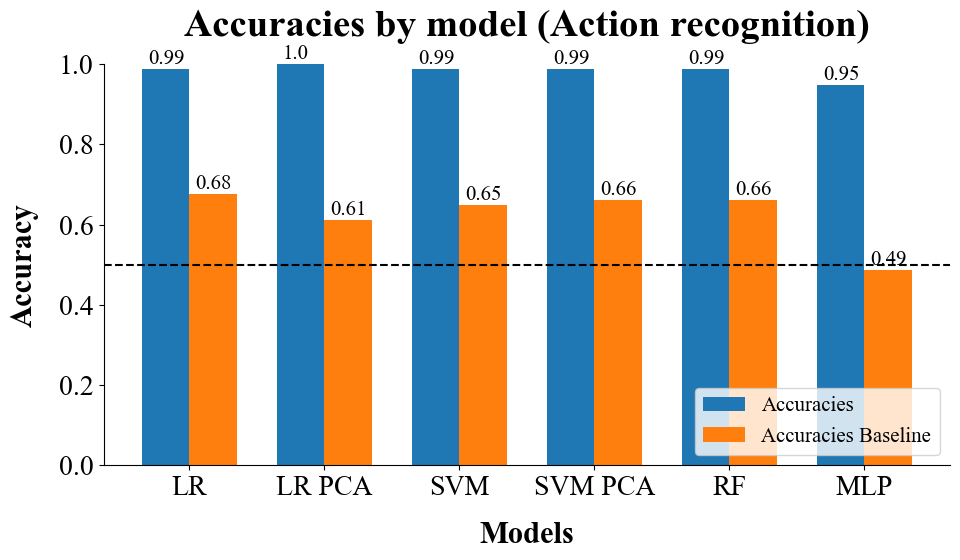

In [29]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies.keys()

dataset_values = [accuracies[model] for model in models]
baseline_values = [accuracies_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (Action recognition)')

ax.set_ylim(0,1)

ax.legend(loc = 'lower right')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.axhline(0.5, linestyle='--', color='k')
plt.legend(loc='lower right', fontsize=15)

plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ExObs.png')
plt.show()